In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
df = pd.read_json('transactions.txt', lines=True)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## Data Cleaning

In [3]:
# Replacing white space with nan

df = df.replace('', np.nan)

In [4]:
# Checking which columns are empty and removing

nan_col = df.columns[df.isna().all()].tolist()
df.drop(columns=nan_col, inplace=True)

print("Empty columns that were removed:")
print(nan_col)

Empty columns that were removed:
['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']


In [5]:
# Account Number and Customer Id columns appear to be equal

df['accountNumber'].equals(df['customerId'])

True

In [6]:
# Removing customerId as it is a duplicate of accountNumber

df.drop(columns=['customerId'], inplace=True)

In [7]:
# Exploring transactionType column

df['transactionType'].unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', nan], dtype=object)

In [8]:
# counts of unique values in transactionType

df['transactionType'].value_counts(dropna=False)

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
NaN                        698
Name: transactionType, dtype: int64

In [9]:
# describing transactionAmount base on transactionType.
df.groupby('transactionType')['transactionAmount'].describe()

,count,mean,std,min,25%,50%,75%,max
transactionType,,,,,,,,
ADDRESS_VERIFICATION,20169.0,0.000000,0.000000,0.0,0.000,0.00,0.00,0.00
PURCHASE,745193.0,140.621698,147.942584,0.0,37.110,91.80,195.45,2011.54
REVERSAL,20303.0,138.984017,147.889733,0.0,33.375,92.01,192.98,1435.64


In [10]:
# Removing address_verification rows due to all of the transactionAmounts being 0.

df.drop(df[df['transactionType'] == 'ADDRESS_VERIFICATION'].index, inplace=True)

In [11]:
# Filling NaN with purchase to keep data

df['transactionType'] = df['transactionType'].fillna('PURCHASE')

In [12]:
# checking which columns contain NaN values
df.isnull().sum()

accountNumber                  0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4456
merchantCountryCode          709
posEntryMode                3970
posConditionCode             400
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType                0
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

In [13]:
# Total amount of rows with NaN values
df.isnull().any(axis=1).sum()

8804

In [14]:
# Dropping all rows with NaN value
df = df.dropna()

In [15]:
# Changing transactionDatetime. All transactions occurred in 2026, year is unneeded

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['Month'] = df['transactionDateTime'].dt.month
df['day'] = df['transactionDateTime'].dt.day
df['hour'] = df['transactionDateTime'].dt.hour
df['minute'] = df['transactionDateTime'].dt.minute

# Cyclic encoding for hour and minute
df['hourSin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hourCos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minuteSin'] = np.sin(2 * np.pi * df['minute'] / 24)
df['minuteCos'] = np.cos(2 * np.pi * df['minute'] / 24)

In [16]:
# Do not need columns
df.drop(columns=['transactionDateTime'], inplace=True)
df.drop(columns=['hour'], inplace=True)
df.drop(columns=['minute'], inplace=True)

In [17]:
# Reformatting other date columns

df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month

df['accountOpenYear'] = pd.to_datetime(df['accountOpenDate']).dt.year
df['accountOpenMonth'] = pd.to_datetime(df['accountOpenDate']).dt.month
df['accountOpenDay'] = pd.to_datetime(df['accountOpenDate']).dt.day

df['lastAddressChangeYear'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.year
df['lastAddressChangeMonth'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.month
df['lastAddressChangeDay'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.day

# removing unneeded columns
df.drop(columns=['currentExpDate'], inplace=True)
df.drop(columns=['accountOpenDate'], inplace=True)
df.drop(columns=['dateOfLastAddressChange'], inplace=True)

In [18]:
# Dropping merchantName as merchantCategory will be used
df.drop(columns=['merchantName'], inplace=True)

## Encoding

In [19]:
# Unique values in merchantCategoryCode
merch_cat = df['merchantCategoryCode'].unique()
merch_cat

array(['rideshare', 'entertainment', 'mobileapps', 'fastfood',
       'food_delivery', 'auto', 'online_retail', 'gym', 'health',
       'personal care', 'food', 'fuel', 'online_subscriptions',
       'online_gifts', 'hotels', 'airline', 'furniture', 'subscriptions',
       'cable/phone'], dtype=object)

In [20]:
# One-hot encoding for merchantCategoryCode

df['MerchantCategory_Full'] = df['merchantCategoryCode']

df = pd.get_dummies(df, columns=['merchantCategoryCode'], prefix = 'merchantCat', drop_first=False)

## Exploratory Data Analysis

In [21]:
# Amount of fraud and legitimate transactions

print(df['isFraud'].value_counts())
print('\nPercentage Fraud:', round((df['isFraud'].value_counts() [1] / len(df)) * 100 , 4))

False    745524
True      11866
Name: isFraud, dtype: int64

Percentage Fraud: 1.5667


In [22]:
# Amount of times the card was preent during the transaction

df['cardPresent'].value_counts()

False    408535
True     348855
Name: cardPresent, dtype: int64

In [23]:
# How the card was swiped?

print('Swiped Magnetic Strip: ', (df['posEntryMode'] == '02').sum())
print('Chip Reader: ', (df['posEntryMode'] == '05').sum())
print('Contactless: ', (df['posEntryMode'] == '09').sum())
print('Chip Reader Failed/ swiped magnetic strip: ', (df['posEntryMode'] == '80').sum())
print('Dwiped Magnetic Strip & CVV: ', (df['posEntryMode'] == '90').sum())

Swiped Magnetic Strip:  189665
Chip Reader:  304955
Contactless:  229053
Chip Reader Failed/ swiped magnetic strip:  14799
Dwiped Magnetic Strip & CVV:  18918


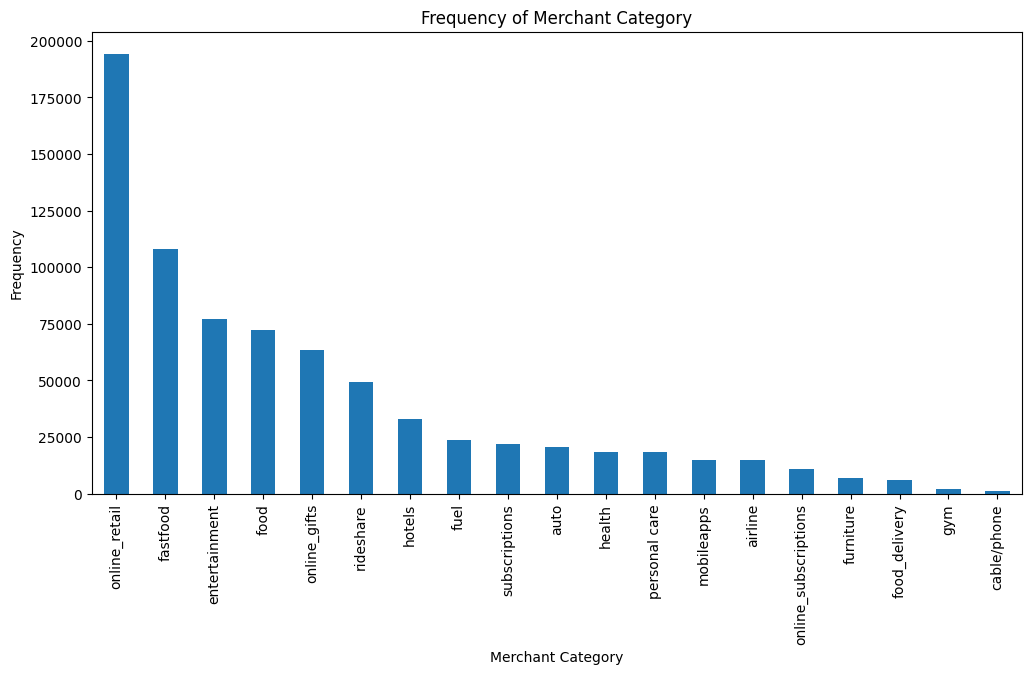

In [25]:
# Bar graph for Merhcant Category 

cat_counts = df['MerchantCategory_Full'].value_counts()

cat_counts = cat_counts.sort_values(ascending=False)

plt.figure(figsize=(12,6))
cat_counts.plot(kind='bar')
plt.xlabel('Merchant Category')
plt.ylabel('Frequency')
plt.title('Frequency of Merchant Category')
plt.show()

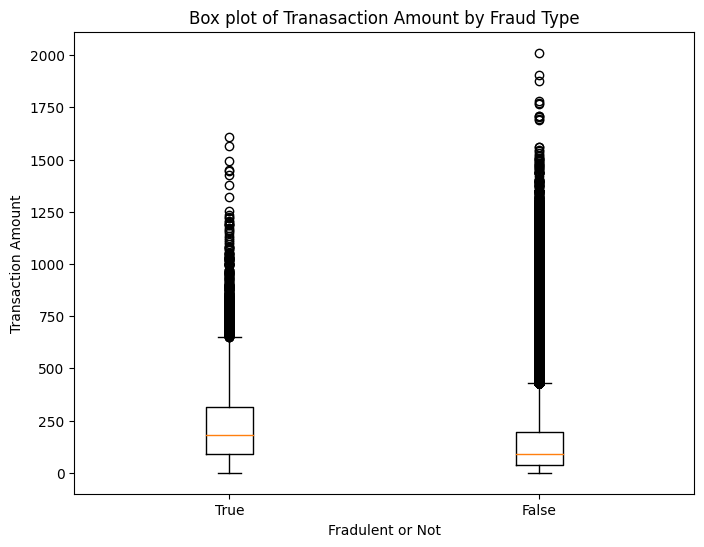

In [31]:
# Boxplot for tranasaction amount by fraud

fraud_true = df[df['isFraud'] == True]['transactionAmount']
fraud_false = df[df['isFraud'] == False]['transactionAmount']

plt.figure(figsize=(8,6))
plt.boxplot([fraud_true, fraud_false], labels=['True','False'])
plt.xlabel('Fradulent or Not')
plt.ylabel('Transaction Amount')
plt.title('Box plot of Tranasaction Amount by Fraud Type')
plt.show()

In [35]:
# how many unique accounts

df['accountNumber'].nunique()

4997

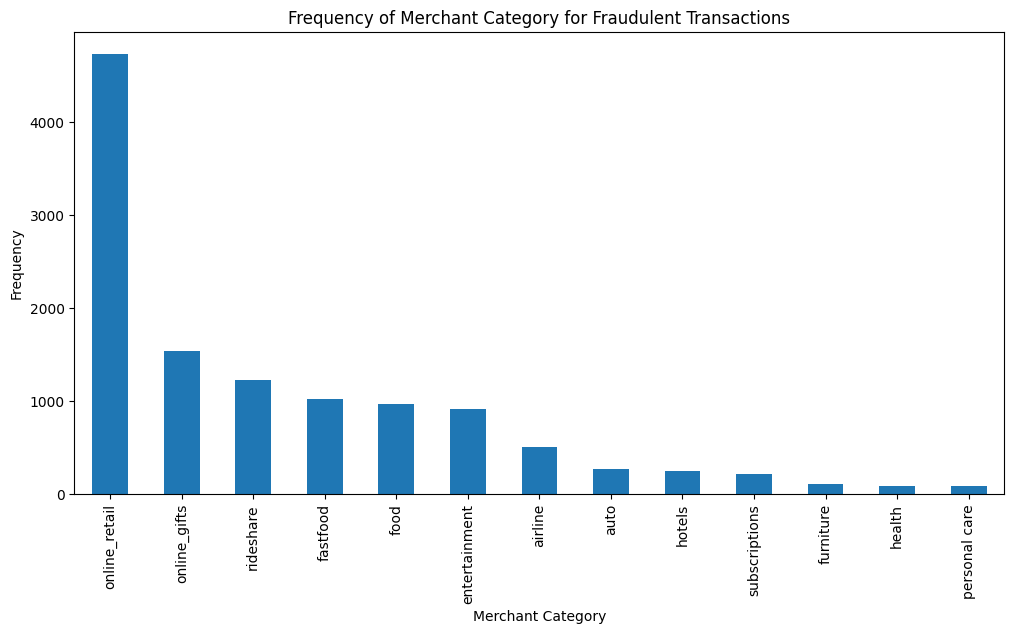

In [42]:
# Merchant categories for fradulent cases


fraud_df = df[df['isFraud'] == True]


cat_counts = fraud_df['MerchantCategory_Full'].value_counts()

cat_counts = cat_counts.sort_values(ascending=False)


plt.figure(figsize=(12, 6))
cat_counts.plot(kind='bar')
plt.xlabel('Merchant Category')
plt.ylabel('Frequency')
plt.title('Frequency of Merchant Category for Fraudulent Transactions')
plt.show()